In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from keras.datasets import mnist

from optimizers import SGD, Nesterov, Adam, LBFGS

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train[(y_train == 1) | (y_train == 7)].reshape((-1, np.prod(X_train.shape[1:]))) / 255.
y_train = 2 * (y_train[(y_train == 1) | (y_train == 7)] == 1) - 1
X_test = X_test[(y_test == 1) | (y_test == 7)].reshape((-1, np.prod(X_test.shape[1:]))) / 255.
y_test = 2 * (y_test[(y_test == 1) | (y_test == 7)] == 1) - 1

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(13007, 784) (13007,)
(2163, 784) (2163,)


In [3]:
pca_20 = PCA(n_components=20)
X_train_20 = pca_20.fit_transform(X_train)
X_test_20 = pca_20.transform(X_test)

print(X_train_20.shape, X_test_20.shape)

(13007, 20) (2163, 20)


In [4]:
# constructs 2d array of data feature coefficients in quadratic test function
# equivalent to a linear system with parameter vector w, ie.
# y * (x.T @ W @ x + v.T @ x + b) == get_quadratic(x, y) @ w
def get_quadratic(X_data, y_data):
    quad_term = (X_data[:, :, np.newaxis] * X_data[:, np.newaxis, :]).reshape((len(X_data), -1))
    quadratic = y_data[:, np.newaxis] * np.hstack((quad_term, X_data, np.ones((len(X_data), 1))))
    return quadratic.astype(np.float128)

quad_train = get_quadratic(X_train_20, y_train)
quad_test = get_quadratic(X_test_20, y_test)

print(quad_train.shape, quad_test.shape)

(13007, 421) (2163, 421)


In [5]:
# loss function over entire training set
def loss_function(w, train_data, lam=1e-3):
    return np.sum(np.log(1 + np.exp(-train_data @ w))) / len(train_data) + lam / 2 * np.sum(w ** 2)

# gradient function allows for different batches
def loss_gradient(w, data_batch, lam=1e-3):
    exp_quad = np.exp(-data_batch @ w)
    coef = exp_quad / (1 + exp_quad)
    return np.sum(-data_batch * coef[:, np.newaxis], axis=0) / len(data_batch) + lam * w

In [6]:
def eval_test_func(w, train_data, test_data):
    eval_train = (train_data @ w > 0).astype(int)
    eval_test = (test_data @ w > 0).astype(int)
    correct_train = sum(eval_train)
    correct_test = sum(eval_test)
    acc_train = correct_train / len(eval_train)
    acc_test = correct_test / len(eval_test)
    print(f'train correct: {correct_train}, train accuracy: {acc_train}')
    print(f'test correct: {correct_test}, test accuracy: {acc_test}')

def visualize_histories(loss_hist, grad_norms):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].title.set_text('Objective loss vs. epoch')
    axs[0].plot(loss_hist)
    axs[1].title.set_text('Gradient norm vs. iteration')
    axs[1].plot(grad_norms)
    plt.show()

In [7]:
params = {
    "data": quad_train,
    "batch_size": 20,
    "step_size": 0.01,
    "epochs": 10,
    "loss": loss_function,
    "grad": loss_gradient,
}

sgd = SGD(**params)
w_sgd = sgd.minimize()
eval_test_func(w_sgd, quad_train, quad_test)

train correct: 12919, train accuracy: 0.9932344122395633
test correct: 2142, test accuracy: 0.9902912621359223


In [8]:
params = {
    "data": quad_train,
    "batch_size": 20,
    "step_size": 0.001,
    "epochs": 10,
    "loss": loss_function,
    "grad": loss_gradient,
}

nesterov = Nesterov(**params)
w_nesterov = nesterov.minimize()
eval_test_func(w_nesterov, quad_train, quad_test)

train correct: 12933, train accuracy: 0.9943107557469055
test correct: 2146, test accuracy: 0.9921405455386038


In [9]:
params = {
    "data": quad_train,
    "batch_size": 20,
    "step_size": 0.01,
    "epochs": 10,
    "loss": loss_function,
    "grad": loss_gradient,
}

adam = Adam(**params)
w_adam = adam.minimize()
eval_test_func(w_adam, quad_train, quad_test)

train correct: 12956, train accuracy: 0.9960790343661106
test correct: 2144, test accuracy: 0.9912159038372631


In [10]:
params = {
    "data": quad_train,
    "batch_size": 500,
    "step_size": None,
    "epochs": 10,
    "loss": loss_function,
    "grad": loss_gradient,
    "m": 5,
    "update_freq": 10,
}

lbfgs = LBFGS(**params)
w_lbfgs = lbfgs.minimize()
eval_test_func(w_lbfgs, quad_train, quad_test)

train correct: 12459, train accuracy: 0.9578688398554625
test correct: 2079, test accuracy: 0.9611650485436893


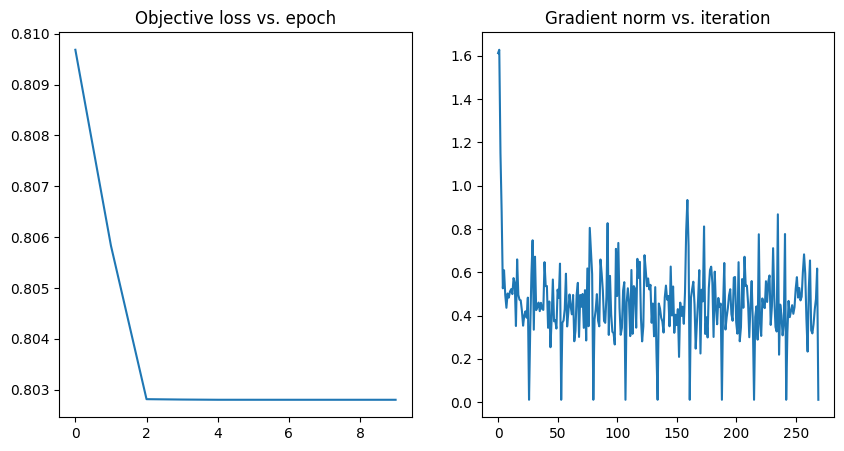

In [11]:
visualize_histories(*lbfgs.get_histories())